<a href="https://colab.research.google.com/github/nandwanatarun/EVA-DeepLearning/blob/Phase2_Session-5/Phase2_Session_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-20,20)),
                                       transforms.RandomAffine(1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False




CUDA Available? True

Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.4001)
 - std: tensor(0.2598)
 - var: tensor(0.0675)
torch.Size([64, 1, 28, 28])
torch.Size([64])


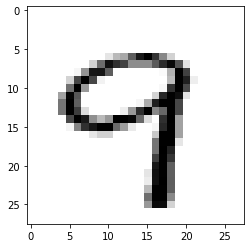

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(transforms.ToPILImage()(train_data.numpy()))

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on


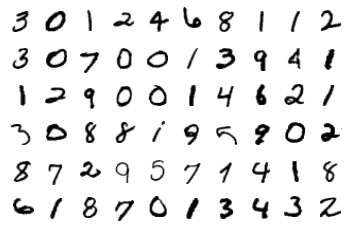

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


The model

Let's start with the model we first saw


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        ) # output_size = 24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            # nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU()
        ) # output_size = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        ) # output_size = 7

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        ) # output_size = 5

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1)
        ) # output_size = 5


        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


Model Params

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help


In [9]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
        Dropout2d-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1,


Training and Testing

Looking at logs can be boring, so we'll introduce tqdm progressbar to get cooler logs.

Let's write train and test functions


In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Loss=2.464254856109619 Batch_id=0 Accuracy=7.81:   0%|          | 1/938 [00:00<02:08,  7.30it/s]

EPOCH: 0


Loss=0.08801402151584625 Batch_id=937 Accuracy=94.55: 100%|██████████| 938/938 [01:40<00:00,  9.31it/s]
Loss=0.02119281142950058 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:41,  9.26it/s]


Test set: Average loss: 0.0427, Accuracy: 9860/10000 (98.60%)

EPOCH: 1


Loss=0.04549463093280792 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [01:41<00:00,  9.21it/s]
Loss=0.05124613270163536 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:41,  9.21it/s]


Test set: Average loss: 0.0321, Accuracy: 9893/10000 (98.93%)

EPOCH: 2


Loss=0.1211022436618805 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [01:40<00:00,  9.35it/s]
Loss=0.04349609091877937 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:44,  8.99it/s]


Test set: Average loss: 0.0295, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


Loss=0.22508203983306885 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [01:41<00:00,  9.29it/s]
Loss=0.05190959572792053 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:45,  8.92it/s]


Test set: Average loss: 0.0304, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.0009785817237570882 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [01:41<00:00,  9.23it/s]
Loss=0.002722893375903368 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:48,  8.66it/s]


Test set: Average loss: 0.0250, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.07356259226799011 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [01:40<00:00,  9.36it/s]
Loss=0.028789125382900238 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:46,  8.80it/s]


Test set: Average loss: 0.0235, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.06930013000965118 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:41<00:00,  9.25it/s]
Loss=0.0030907716136425734 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:42,  9.16it/s]


Test set: Average loss: 0.0229, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.006498475559055805 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [01:41<00:00,  9.20it/s]
Loss=0.09847795218229294 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:41,  9.20it/s]


Test set: Average loss: 0.0227, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.010719752870500088 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [01:40<00:00,  9.30it/s]
Loss=0.05283450335264206 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:50,  8.45it/s]


Test set: Average loss: 0.0230, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.042418815195560455 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:41<00:00,  9.23it/s]
Loss=0.0032176661770790815 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:42,  9.15it/s]


Test set: Average loss: 0.0228, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.02006981149315834 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [01:42<00:00,  9.19it/s]
Loss=0.027892107143998146 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:39,  9.42it/s]


Test set: Average loss: 0.0216, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.0037266032304614782 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [01:41<00:00,  9.25it/s]
Loss=0.06411340087652206 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:46,  8.81it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.0011062927078455687 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [01:40<00:00,  9.33it/s]
Loss=0.08860902488231659 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:38,  9.56it/s]


Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.014213788323104382 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:41<00:00,  9.24it/s]
Loss=0.15749241411685944 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:42,  9.11it/s]


Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.01938357949256897 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [01:40<00:00,  9.30it/s]



Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)



Text(0.5, 1.0, 'Test Accuracy')

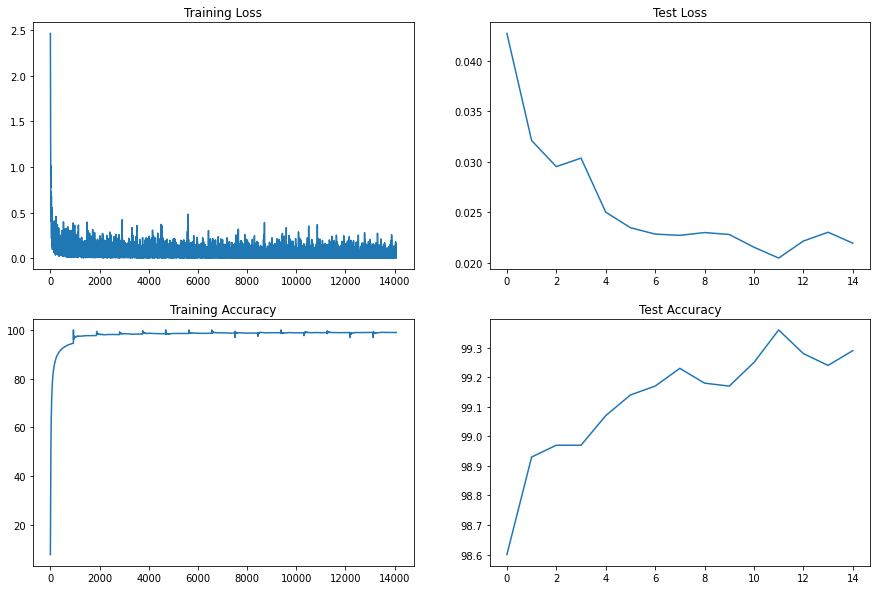

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")